In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 41kB/s 


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
try:
    corpus = pd.read_csv('corpus.csv', index_col='id')
except FileNotFoundError:
    if os.path.exists('drive'):
        corpus_path = 'drive/MyDrive/project_sber/corpus.csv'

        try:
            corpus = pd.read_csv(corpus_path, index_col='id')
        except:
            print("No file(corpus.csv) in the google drive folder project sber")

In [ ]:
values = {'venue': corpus['venue'].mode()[0],
          'journalName': corpus['journalName'].mode()[0],
          'fieldsOfStudy': corpus['fieldsOfStudy'].mode()[0]
         }

corpus.fillna(value=values,inplace=True)
corpus.isna().sum()

recency                     0
venue                       0
journalName                 0
fieldsOfStudy               0
max_hindex                  0
n_authors                   0
title_len                   0
abstract_len                0
citations_n                 0
venue_hindex                0
venue_mean_cite             0
avg_hindices                0
sum_hindices                0
ratio_hindex_paper_count    0
topic_mean_cite             0
prim_author_paper_count     0
dtype: int64

In [ ]:
X.dtypes[X.dtypes == 'object']

id               object
venue            object
journalName      object
fieldsOfStudy    object
dtype: object

I have decide to consider only subset of articles as the heavy tail distribution is quite difficult to model

In [37]:
subset = corpus[corpus.citations_n < 10].copy()

In [38]:
y = subset['citations_n']
X = subset.drop(columns=['citations_n'])

# split data to 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ['venue','journalName','fieldsOfStudy']

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)
test_pool = Pool(X_test, 
                 cat_features=cat_features) 

model = CatBoostRegressor(loss_function='RMSE', eval_metric='R2')
# train the model
model.fit(train_pool, verbose=100)
# make the prediction using the resulting model
preds = model.predict(test_pool)
preds

Learning rate set to 0.123164
0:	learn: 0.1259290	total: 644ms	remaining: 10m 42s
100:	learn: 0.6031070	total: 46.8s	remaining: 6m 56s
200:	learn: 0.6088378	total: 1m 32s	remaining: 6m 6s
300:	learn: 0.6120478	total: 2m 15s	remaining: 5m 15s
400:	learn: 0.6144928	total: 2m 59s	remaining: 4m 28s
500:	learn: 0.6163590	total: 3m 43s	remaining: 3m 42s
600:	learn: 0.6180894	total: 4m 27s	remaining: 2m 57s
700:	learn: 0.6194615	total: 5m 12s	remaining: 2m 13s
800:	learn: 0.6207371	total: 5m 58s	remaining: 1m 29s
900:	learn: 0.6221028	total: 6m 41s	remaining: 44.1s
999:	learn: 0.6232761	total: 7m 26s	remaining: 0us


array([-1.86586443e-03,  3.86709361e-02,  3.96148982e+00, ...,
       -9.38948983e-03,  4.45797797e+00,  3.84574305e-03])

In [40]:
print(f"r2_score: {r2_score(y_test, preds)}")

r2_score: 0.6152481871672242


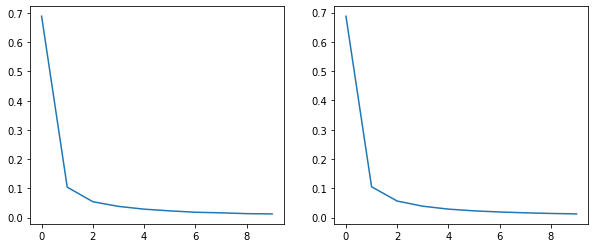

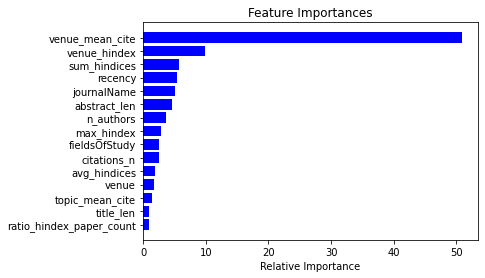

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(y_test.value_counts() / len(y_test))
ax2.plot(y_train.value_counts() / len(y_train))
plt.show()


features = corpus.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()